Figure 4. Heatmap demonstrating differences between model outputs

In [1]:
%pylab inline
import pickle
import glob
import os
import pandas as pd
import numpy as np
import sys
from scipy.special import softmax

sys.path.insert(0, ".")

import seaborn as sns

sns.set()
sns.set_style("ticks")
sns.set_context("paper")


def pd_full(rows=100):
    pd.set_option("display.max_rows", rows)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)
    pd.set_option("display.float_format", "{:20,.3f}".format)
    pd.set_option("display.max_colwidth", None)


pd_full()

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load relevant experiment script
import scripts.run_base_configs_exp as exp
from training.evalmodel import *
from training.ensemble_train import *

In [3]:
# Choose a few specific models to plot, so that it's not overwhelming
models = [
    ["saved_models/ensembles_3_4_folds_0", "4-fold ensemble of Multi-Scale CNN/LSTM (4x ms-C/L)"],
    #     ['saved_models/base_configs_7_multi_scale_cnn_lstm_1', 'Multiscale CNN/LSTM'],
    ["saved_models/base_configs_7_multi_scale_cnn_1", "Multi-Scale CNN (ms-CNN)"],
#     ["saved_models/base_configs_7_cnn_lstm_1", "Pooled CNN/LSTM (p-C/L)"],
    ["saved_models/base_configs_7_base_cnn_1", "Pooled CNN (p-CNN)"],
    ["saved_models/base_configs_7_base_lstm_1", "Base LSTM (b-LSTM)"],
    ["saved_models/base_configs_5_deepconvlstm_0", "DeepConvLSTM reimplementation"],
]

Loading cached data.
Loaded.
(118750, 113) (118750,)


/home/ubuntu/anaconda3/envs/petinsight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/petinsight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(576, 18)
(118750, 113) (118750,)
(576, 18)
(118750, 113) (118750,)
(576, 18)
(118750, 113) (118750,)
(4608, 18)
(118750, 113) (118750,)
(394, 18)


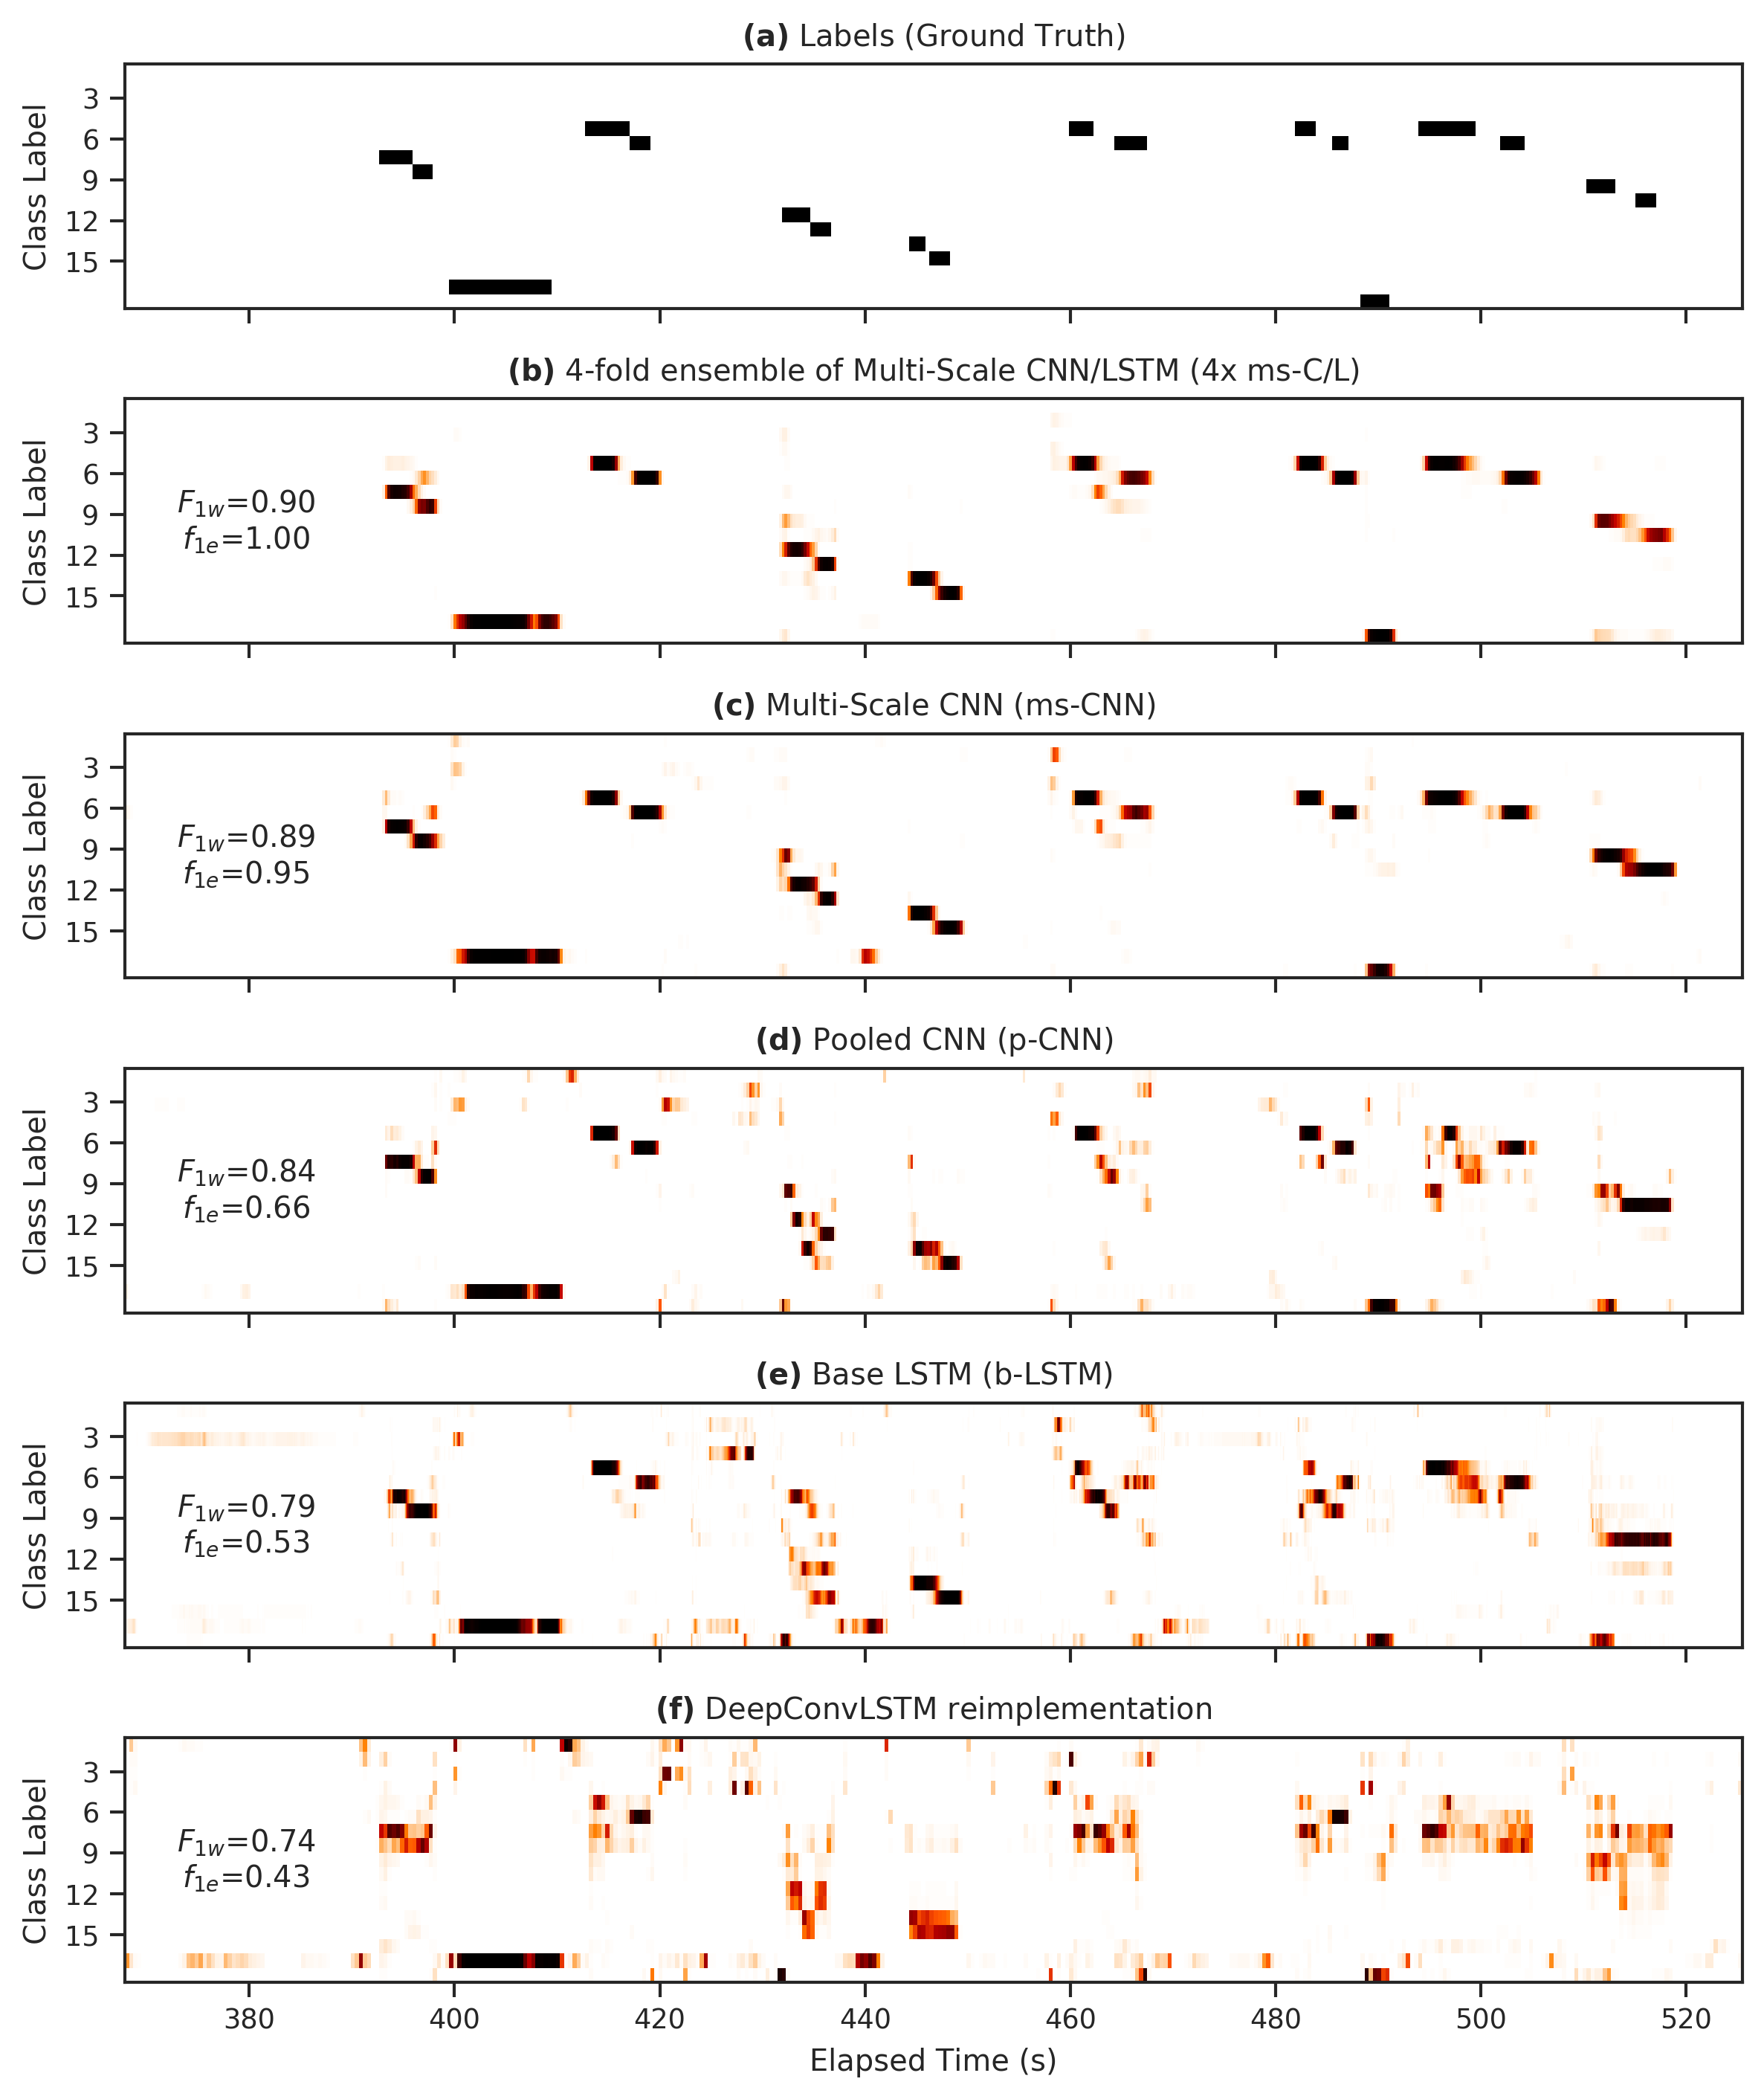

In [4]:
from datasets.opportunity import get_x_y_contig
from datasets import sliding_window_x_y
from torch.utils.data import DataLoader, TensorDataset

start_idx = 1


##
# First, load some data that can be used for testing.

# imin, imax = 0, int(32748 / 2)  # first half of first test run
imin, imax = (
    int(3.37 * 32748 / 10),
    int(4.82 * 32748 / 10),
)  # zoomed-in on a section of first test run

# Load underlying data segment
Xc, ycs, data_spec = get_x_y_contig("test")
Xc = Xc[imin:imax]
ycs = [yc[imin:imax] for yc in ycs]

t0 = 0 + imin / 30.0
tf = len(Xc) / 30.0 + imin / 30

##
# Get plot ready
f, axes = subplots(
    len(models) + 1,
    1,
    sharex=True,
    sharey=True,
    figsize=(8, 2 + 1.5 * len(models)),
    dpi=300,
)
sca(axes[1])

panes = ["b", "c", "d", "e", "f", "g", "h"]

# Cycle through models

for i, (fn, name) in enumerate(models):

    # Load model
    em = load_eval_model_from_dir(fn)

    em.trainer._restore()

    # Load underlying data segment
    Xc, ycs, data_spec = get_x_y_contig("test")
    print(Xc.shape, ycs[0].shape)
    Xc = Xc[imin:imax]
    ycs = [yc[imin:imax] for yc in ycs]

    # Properly window data for this model
    X, ys = sliding_window_x_y(
        Xc,
        ycs,
        win_len=em.trainer.win_len,
        step=int(em.trainer.win_len / 2),
        shuffle=False,
    )
    dl = DataLoader(
        TensorDataset(torch.Tensor(X), *[torch.Tensor(y).long() for y in ys]),
        batch_size=em.eval_batch_size,
        shuffle=False,
    )

    # Run on this data subset
    em.run_test_set(dl)

    # Calc new metrics for *just* this subset
    em.calc_metrics()
    em.calc_ward_metrics()

    # Plot results for this model
    yp = softmax(em.outputsraw[:, :].T, axis=1)
    print(yp.shape)
    sca(axes[i + 1])
    
    if 'DeepConvLSTM' in name:
        _tf = t0 + len(yp)*12.0/30.0
    elif 'Base' in name:
        _tf = t0 + len(yp)*1.0/30.0
    else:
        _tf = t0 + len(yp)*8/30.0
    
    kwargs = dict(
        aspect="auto",
        cmap="gist_heat_r",
        extent=(t0, _tf, len(em.target_names) + 0.5, start_idx - 0.5),
    )
    
    imshow(yp.T[start_idx:, :], **kwargs)
    title(f"$\\bf{{({panes[i]})}}$ {name}")
    annotate(
        f"$F_{{1w}}$={em.f1:.2f}\n" f"$f_{{1e}}$={em.event_f1:.2f}",
        xy=(0.075, 0.5),
        horizontalalignment="center",  #'right',
        verticalalignment="center",
        xycoords="axes fraction",
    )
    ylabel("Class Label")
    yticks(np.arange(0, len(em.target_names), 3))

# Plot labels/targets in top plot
y = np.zeros_like(yp)
y[np.arange(y.shape[0]), em.targets[:]] = 1
sca(axes[0])
title("$\\bf{(a)}$ Labels (Ground Truth)")

imshow(y.T[start_idx:, :], **kwargs)

ylabel("Class Label")
sca(axes[-1])
xlabel("Elapsed Time (s)")
# yticks(np.arange(0,len(em.target_names),2))

tight_layout()
plt.savefig('stripchart heatmaps.png')
show()

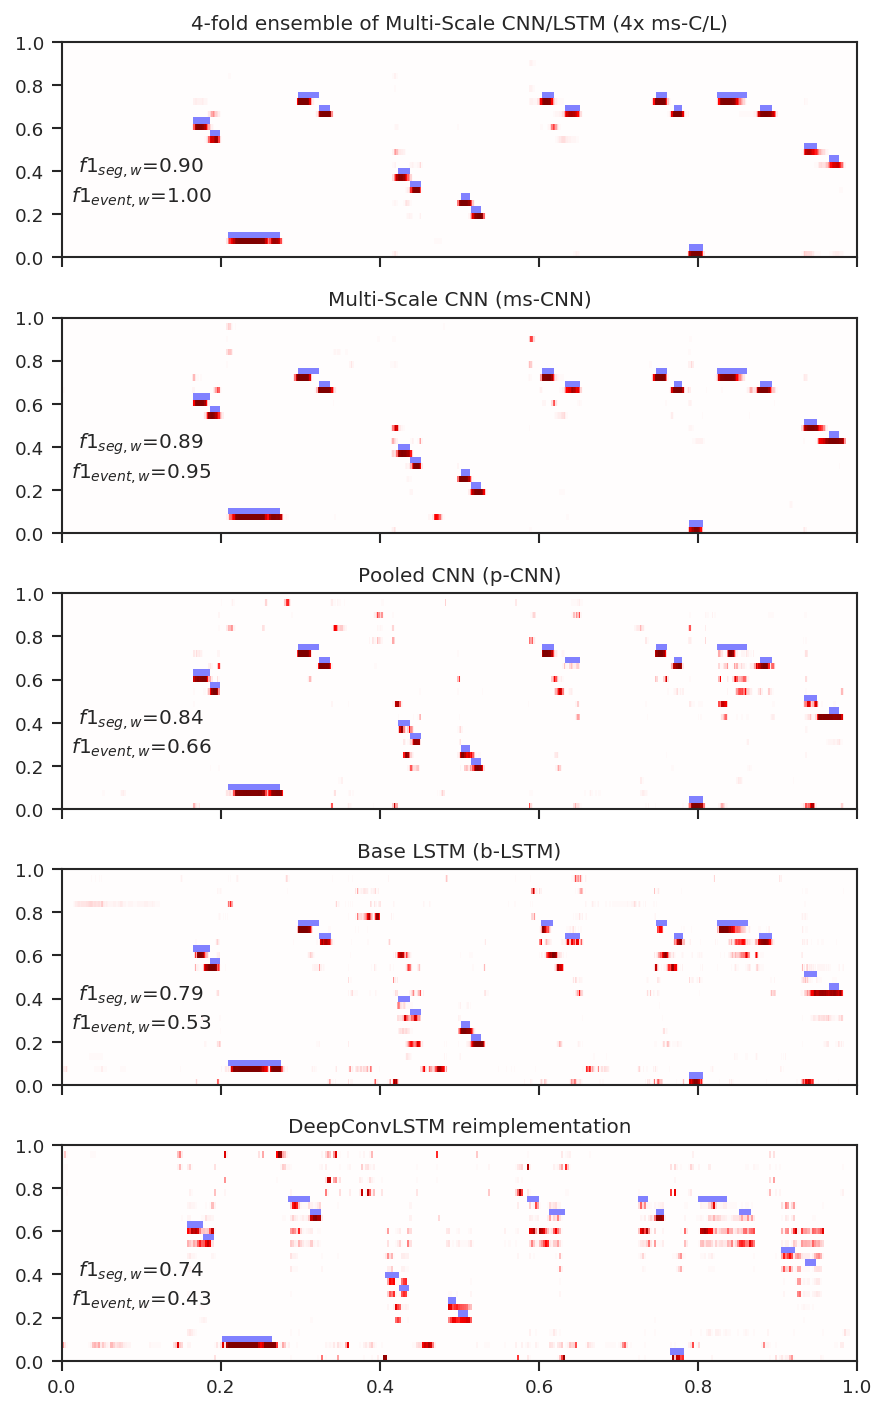

In [5]:
# Alternative plot style...

# Get plot ready
f, axes = subplots(
    len(models),
    1,
    sharex=True,
    sharey=True,
    figsize=(6, 2 + 1.5 * len(models)),
    dpi=150,
)
sca(axes[1])

kwargs = dict(aspect="auto", cmap="seismic", extent=(0, 1, 0, 1), clim=[-1, 1])

# Cycle through models

for i, (fn, name) in enumerate(models):
    # Load model
    em = load_eval_model_from_dir(fn)
    em.trainer._restore()

    # Properly window data for this model
    X, ys = sliding_window_x_y(
        Xc,
        ycs,
        win_len=em.trainer.win_len,
        step=int(em.trainer.win_len / 2),
        shuffle=False,
    )
    dl = DataLoader(
        TensorDataset(torch.Tensor(X), *[torch.Tensor(y).long() for y in ys]),
        batch_size=em.eval_batch_size,
        shuffle=False,
    )

    # Run on this data subset
    em.run_test_set(dl)
    # Calc new metrics for *just* this subset
    em.calc_metrics()
    em.calc_ward_metrics()

    # Plot results for this model
    yp = softmax(em.outputsraw[:, :].T, axis=1)

    y = np.zeros_like(yp)
    y[np.arange(y.shape[0]), em.targets[:]] = 1

    # Interleave target rows (negative, so they are plotted blue)
    #   and predictions (positive, so they are red)
    s = 2
    c = np.zeros((yp.shape[0], y.shape[1] * s), dtype=yp.dtype)
    c[:, 0::s] = -y * 0.25
    c[:, 1::s] = yp

    sca(axes[i])
    imshow(c.T[start_idx * s :, :], **kwargs)
    title(name)
    annotate(
        f"$f1_{{seg,w}}$={em.f1:.2f}\n" f"$f1_{{event,w}}$={em.event_f1:.2f}",
        xy=(0.1, 0.35),
        horizontalalignment="center",  #'right',
        verticalalignment="center",
    )


tight_layout()
show()